In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
import math
from ddeint import ddeint
import copy

# 1 Load data

In [2]:
import scipy
import scipy.io as sio


In [3]:
row_idx = [];
for i in ['A','B','C','D','E','F']:
    for j in np.arange(1,9,1):
        row_idx.append(i+str(j))
row_idx.append('Time')

In [4]:
filename_OD = '../data/d20220817_ODphagecounting_M9Glu.mat';
mat_contents = sio.loadmat(filename_OD)
time_ = mat_contents['timeVector'][0]

df_glu = pd.DataFrame(mat_contents['blankedOD'])
df_glu.loc['Time'] = time_
df_glu.index = row_idx

In [24]:
filename_OD = '../data/d20220817_ODphagecounting_M9Mal.mat';
mat_contents = sio.loadmat(filename_OD)
time_ = mat_contents['timeVector'][0]

df_mal = pd.DataFrame(mat_contents['blankedOD'])
df_mal.loc['Time'] = time_
df_mal.index = row_idx

## 2 Plot Sfig. 6b

In [5]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import copy

def f0(x, t, ps):
    try:
        k = ps['k'].value
        v = ps['v'].value
        e = ps['e'].value
    except:
        k, v, e = ps
    R, N  = x; 
    phi = R/(k+R);
    dR = -e*phi*v*N
    dN = v*phi*N
    return [dR, dN]

def g0(t, x0, ps):
    x = odeint(f0, x0, t, args=(ps,))
    return x[:,1]

def residual0(ps, ts, tdata, xdata):
    res_reweight = np.array([]); 
    ds_arr = list(xdata.keys())
    
    k = 0;
    x00 = np.zeros(len(ds_arr)); 
    for ds_ in ds_arr: 
        x00[k] = xdata[ds_][0];
        k = k+1;

    for ds_ in ds_arr: 
        time_raw = tdata; 
        data_real = xdata[ds_]; 
        data_simul = np.zeros(len(time_raw)); 
        
        x0 = [1, np.mean(x00)];
        OD_tmp = g0(ts, x0, ps); 
        z = 0; 
        for j in time_raw:
            t_i = np.where(ts>j)[0][0];
            data_simul[z] = OD_tmp[t_i];
            z = z+1;
        res_reweight = np.append(res_reweight, data_simul - data_real)
    return res_reweight

In [8]:
#M9Glu
tdata = df_glu.loc['Time'][6:130] - df_glu.loc['Time'][6];
xdata = {};
j = 0; 
for i in ['C5','C6']:
    xdata[j] = df_glu.loc[i][6:130].to_numpy();
    j = j+1;

In [43]:
N = 10; 
kb_glu = np.zeros(N); 
vb_glu = np.zeros(N); 
eb_glu = np.zeros(N); 

t_0 = time.time() 
for i_ in range(N):
    
    t = linspace(0,800,800);  
    params = Parameters()
    params.add('k', value=0.2, min=0.1, max=1)
    params.add('v', value=np.log(2)/20, min=np.log(2)/100, max=1/2)
    params.add('e', value=0.1, min=0.01, max=100)

    result = minimize(residual0, params, args=(t,tdata,xdata), method='dual_annealing',nan_policy='omit')
    
    kb = result.params['k'].value;
    vb = result.params['v'].value;
    eb = result.params['e'].value;
    
    kb_glu[i_] = kb;
    vb_glu[i_] = vb; 
    eb_glu[i_] = eb;

elapsed = time.time() - t_0
print(elapsed)

224.6562020778656


In [45]:
for arr in (kb_glu, vb_glu, eb_glu):
    print(np.mean(arr))
    print(np.std(arr)/np.sqrt(N))
    print('===========')

1.0
0.0
0.022205218314736215
1.4421213983397455e-09
2.138357714668583
1.127500298901577e-07


In [47]:
idx_ = 0; 

kb = kb_glu[idx_]; 
vb = vb_glu[idx_]
eb = eb_glu[idx_];

In [9]:
kb = 1.0;
vb = 0.022205218314736215;
eb = 2.138357714668583;

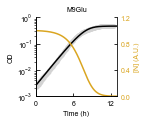

In [14]:
#############################

ylim_max = 0.5; 
data_color = 'lightgray'
model_cell_color = 'black'; #[44/255,162/255,95/255,1]#'lightgreen'


##############################

myt = (df_glu.loc['Time'].to_numpy()[6:130] - df_glu.loc['Time'].to_numpy()[6])/60; 
t_offset = df_glu.loc['Time'].to_numpy()[6]/60; 

##############################
psb_glu = [kb, vb, eb];

tsb = linspace(0,800,800);

k = 0;
ds_arr = list(xdata.keys())
x00 = np.zeros(len(ds_arr)); 
for ds_ in ds_arr: 
    x00[k] = xdata[ds_][0];
    k = k+1;

x0 = [1, np.mean(x00)];
x = odeint(f0, x0, tsb, args=(psb_glu,))

myF = x[:,0]; 

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (1.45,1.45)})
ax = plt.subplot(1,1,1)

'''
plt.fill_between(tsb[:idt1]+t_offset, ylim_max,color='darkgrey',alpha=0.5,edgecolor=None)
plt.fill_between(tsb[idt1-1:idt2]+t_offset, ylim_max,color='lightgrey',alpha=0.5,edgecolor=None)
plt.fill_between(tsb[idt2-1:]+t_offset, ylim_max,  color='white',alpha=0.5, edgecolor=None)
'''


for i in ['C5','C6']:
    ydata = df_glu.loc[i][6:130].to_numpy();
    
    if i == 'C5':
        plt.plot(myt, ydata,'o',markersize=3, color=data_color,label='Data')
    else:
        plt.plot(myt, ydata,'o',markersize=3, color=data_color)
plt.title('M9Glu')
plt.plot((tsb+t_offset)/60, x[:,1],linewidth=1.5,  color=model_cell_color, label='Model')
ax.set_ylabel('OD', color=model_cell_color) 
ax.tick_params(axis='y', labelcolor=model_cell_color)
ax.set_xlabel('Time (h)')
plt.xticks([0,6,12],[0,6,12])
#ax.set_ylabel('$OD_{600}$')
ax.set_xlim((0,13))
plt.yscale('log')
plt.ylim((1e-3,1))
ax.set_yticks([1e-3,1e-2,1e-1,1e0])
#ax.set_yticklabels(['$10^{-3}$','$10^{-1}$','$10^{1}$'])

ax2 = ax.twinx()
ax2.plot((tsb+t_offset)/60, x[:,0],linewidth=1.5,  color='goldenrod', label='Model (nutrient)')
ax2.set_ylabel('[N] (A.U.)', color='goldenrod') 
ax2.tick_params(axis='y', labelcolor='goldenrod')
ax2.set_ylim((0,1.2))
ax2.set_yticks([0, 0.4,0.8, 1.2])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")

#ax.legend(frameon=False,loc='upper left',ncol=1)
plt.savefig('../output/Sfig6b-left.pdf', format='pdf', bbox_inches='tight')

In [15]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook("../output/Sfig6b.xlsx")
writer = pd.ExcelWriter("../output/Sfig6b.xlsx", engine = 'xlsxwriter')

df_tmptmp = pd.DataFrame(); 
df_tmptmp['Time (h)'] = myt;
for i in ['C5','C6']:
    ydata = df_glu.loc[i][6:130].to_numpy();
    df_tmptmp['OD from well '+i] = ydata;
df_tmptmp = df_tmptmp.T
df_tmptmp.to_excel(writer, sheet_name = 'data') 

df_tmptmp = pd.DataFrame(); 
df_tmptmp['Time (h)'] = (tsb+t_offset)/60;
df_tmptmp['OD'] = x[:,1];
df_tmptmp['[N] (A.U.)'] = x[:,0]; 
df_tmptmp = df_tmptmp.T
df_tmptmp.to_excel(writer, sheet_name = 'Fit') 


writer.close()

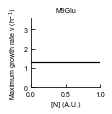

In [18]:
def k_raw(F, thr1b,thr2b,k1b,k2b,k3b):
    if F > thr1b:
        return k1b
    elif F <= thr1b and F > thr2b:
        return k2b
    else:
        return k3b
k_raw = np.vectorize(k_raw)

##############################

thr1b = 2;
thr2b = 1; 

v1b = vb;
v2b = vb;
v3b = vb;

k1b = kb;
k2b = kb;
k3b = kb;

##############################

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (1.6,1.6)})
ax1 = plt.subplot(1,1,1)
plt.title('M9Glu')
#plt.plot(myt, data,'o',markersize=7.5, color='grey',label='Data')
myF = x[:,0]; 
idt1 = np.where(myF<thr1b)[0][0];
#idt2 = np.where(myF<thr2b)[0][0];

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis="y",direction="in")
ax1.tick_params(axis="x",direction="in")

ax1.fill_between(np.arange(0,thr2b+0.01,0.01),0.06*60, color='white',alpha=0.5, edgecolor=None)
ax1.fill_between(np.arange(thr2b, thr1b+0.01,0.01),0.06*60, color='lightgrey',alpha=0.5, edgecolor=None)
ax1.fill_between(np.arange(thr1b,1.01,0.01),0.06*60, color='darkgrey',alpha=0.5, edgecolor=None)

F = np.linspace(0,1,1000)
color1 = 'k'; 
color2 = 'goldenrod'; 

ax1.plot(F, k_raw(F, thr1b,thr2b,v1b,v2b,v3b)*60,linewidth=1.25,color=color1)
ax1.set_xlabel('[N] (A.U.)')
#ax1.set_ylabel('$v$ (/min)', color=color1)
ax1.set_ylabel('Maximum growth rate v (h$^{-1}$)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim((0,0.06*60))
ax1.set_xlim((0,1))

'''
ax2 = ax1.twinx()
ax2.plot(F, k_raw(F, thr1b,thr2b,k1b,k2b,k3b),linewidth=1.25,color=color2)
#plt.plot(F, k_sigmoidal(F, thr1b,thr2b,v1b,v2b,v3b,h),label='approximation (sigmoid)')
ax2.set_xlabel('Relative food abundance')
ax2.set_ylabel('Monod constant K (A.U.)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.set_ylim((0,1.5))

ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")
'''
plt.tight_layout()
plt.savefig('../output/Sfig6b-right.pdf', format='pdf', bbox_inches='tight')

In [21]:
print(k_raw(F, thr1b,thr2b,v1b,v2b,v3b)[0]*60)

1.332313098884173


# 2 Plot Sfig. 6c

In [22]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import copy

def f0(x, t, ps):
    try:
        k = ps['k'].value
        v = ps['v'].value
        e = ps['e'].value
    except:
        k, v, e = ps
    R, N  = x; 
    phi = R/(k+R);
    dR = -e*phi*v*N
    dN = v*phi*N
    return [dR, dN]

def g0(t, x0, ps):
    x = odeint(f0, x0, t, args=(ps,))
    return x[:,1]

def residual0(ps, ts, tdata, xdata):
    res_reweight = np.array([]); 
    ds_arr = list(xdata.keys())
    
    k = 0;
    x00 = np.zeros(len(ds_arr)); 
    for ds_ in ds_arr: 
        x00[k] = xdata[ds_][0];
        k = k+1;

    for ds_ in ds_arr: 
        time_raw = tdata; 
        data_real = xdata[ds_]; 
        data_simul = np.zeros(len(time_raw)); 
        
        x0 = [1, np.mean(x00)];
        OD_tmp = g0(ts, x0, ps); 
        z = 0; 
        for j in time_raw:
            t_i = np.where(ts>j)[0][0];
            data_simul[z] = OD_tmp[t_i];
            z = z+1;
        res_reweight = np.append(res_reweight, data_simul - data_real)
    return res_reweight

In [25]:
#M9Mal
tdata = df_mal.loc['Time'][6:160] - df_mal.loc['Time'][6];
tdata = tdata.to_numpy()
xdata = {};
j = 0; 
for i in ['C5','C6']:
    xdata[j] = df_mal.loc[i][6:160].to_numpy();
    j = j+1;

In [55]:
N = 10; 

kb_mal = np.zeros(N); 
vb_mal = np.zeros(N); 
eb_mal = np.zeros(N); 

t_0 = time.time() 
for i_ in range(N):
    
    t = linspace(0,1100,1100);  
    
    params = Parameters()
    params.add('k', value=0.2, min=0.1, max=1)
    params.add('v', value=np.log(2)/60, min=np.log(2)/200, max=1/2)
    params.add('e', value=0.1, min=0.01, max=100)

    result = minimize(residual0, params, args=(t,tdata,xdata), method='dual_annealing',nan_policy='omit')
    
    kb = result.params['k'].value;
    vb = result.params['v'].value;
    eb = result.params['e'].value;
    
    kb_mal[i_] = kb;
    vb_mal[i_] = vb; 
    eb_mal[i_] = eb;

elapsed = time.time() - t_0
print(elapsed)

251.77337980270386


In [56]:
for arr in (kb_mal, vb_mal, eb_mal):
    print(np.mean(arr))
    print(np.std(arr)/np.sqrt(N))
    print('===========')

1.0
0.0
0.01858827556302053
1.7316845844235384e-10
2.071759776050249
8.062396386939593e-08


In [57]:
idx_ = 0; 

kb = kb_mal[idx_]; 
vb = vb_mal[idx_]
eb = eb_mal[idx_];

In [26]:
kb = 1.0;
vb = 0.01858827556302053;
eb = 2.071759776050249; 

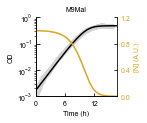

In [27]:
#############################

ylim_max = 0.5; 
data_color = 'lightgray'
model_cell_color = 'black'#[44/255,162/255,95/255,1]#'lightgreen'


##############################

myt = (df_mal.loc['Time'].to_numpy()[6:160] - df_mal.loc['Time'].to_numpy()[6])/60; 
t_offset = df_mal.loc['Time'].to_numpy()[6]/60; 

##############################
psb_mal = [kb, vb, eb];

tsb = linspace(0,1000,1000);

k = 0;
ds_arr = list(xdata.keys())
x00 = np.zeros(len(ds_arr)); 
for ds_ in ds_arr: 
    x00[k] = xdata[ds_][0];
    k = k+1;

x0 = [1, np.mean(x00)];
x = odeint(f0, x0, tsb, args=(psb_mal,))

##############################

myF = x[:,0]; 

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (1.45,1.45)})
ax = plt.subplot(1,1,1)

for i in ['C5','C6']:
    ydata = df_mal.loc[i][6:160].to_numpy();
    
    if i == 'C5':
        plt.plot(myt, ydata,'o',markersize=3, color=data_color,label='Data')
    else:
        plt.plot(myt, ydata,'o',markersize=3, color=data_color)
plt.title('M9Mal')
plt.plot((tsb+t_offset)/60, x[:,1],linewidth=1.5,  color=model_cell_color, label='Model')
ax.set_ylabel('OD', color=model_cell_color) 
ax.tick_params(axis='y', labelcolor=model_cell_color)
ax.set_xlabel('Time (h)')
plt.xticks([0,6,12],[0,6,12])
#ax.set_ylabel('$OD_{600}$')
ax.set_xlim((0,1000/60))
plt.yscale('log')
plt.ylim((1e-3,1))
ax.set_yticks([1e-3,1e-2,1e-1,1e0])
#ax.set_yticklabels(['$10^{-3}$','$10^{-1}$','$10^{1}$'])

ax2 = ax.twinx()
ax2.plot((tsb+t_offset)/60, x[:,0],linewidth=1.5,  color='goldenrod', label='Model (nutrient)')
ax2.set_ylabel('[N] (A.U.)', color='goldenrod') 
ax2.tick_params(axis='y', labelcolor='goldenrod')
ax2.set_ylim((0,1.2))
ax2.set_yticks([0, 0.4,0.8, 1.2])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")

#ax.legend(frameon=False,loc='upper left',ncol=1)
plt.savefig('../output/Sfig6c-left.pdf', format='pdf', bbox_inches='tight')

In [29]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook("../output/Sfig6c.xlsx")
writer = pd.ExcelWriter("../output/Sfig6c.xlsx", engine = 'xlsxwriter')

df_tmptmp = pd.DataFrame(); 
df_tmptmp['Time (h)'] = myt;
for i in ['C5','C6']:
    ydata = df_mal.loc[i][6:160].to_numpy();
    df_tmptmp['OD from well '+i] = ydata;
df_tmptmp = df_tmptmp.T
df_tmptmp.to_excel(writer, sheet_name = 'data') 

df_tmptmp = pd.DataFrame(); 
df_tmptmp['Time (h)'] = (tsb+t_offset)/60;
df_tmptmp['OD'] = x[:,1];
df_tmptmp['[N] (A.U.)'] = x[:,0]; 
df_tmptmp = df_tmptmp.T
df_tmptmp.to_excel(writer, sheet_name = 'Fit') 


writer.close()

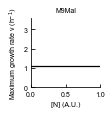

In [31]:
def k_raw(F, thr1b,thr2b,k1b,k2b,k3b):
    if F > thr1b:
        return k1b
    elif F <= thr1b and F > thr2b:
        return k2b
    else:
        return k3b
k_raw = np.vectorize(k_raw)

##############################

thr1b = 2;
thr2b = 1; 

v1b = vb;
v2b = vb;
v3b = vb;

k1b = kb;
k2b = kb;
k3b = kb;

##############################

fontSize=7
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Arial','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
matplotlib.rcParams.update({"figure.figsize": (1.6,1.6)})
ax1 = plt.subplot(1,1,1)
plt.title('M9Mal')
#plt.plot(myt, data,'o',markersize=7.5, color='grey',label='Data')
myF = x[:,0]; 
idt1 = np.where(myF<thr1b)[0][0];
#idt2 = np.where(myF<thr2b)[0][0];

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis="y",direction="in")
ax1.tick_params(axis="x",direction="in")

ax1.fill_between(np.arange(0,thr2b+0.01,0.01),0.06*60, color='white',alpha=0.5, edgecolor=None)
ax1.fill_between(np.arange(thr2b, thr1b+0.01,0.01),0.06*60, color='lightgrey',alpha=0.5, edgecolor=None)
ax1.fill_between(np.arange(thr1b,1.01,0.01),0.06*60, color='darkgrey',alpha=0.5, edgecolor=None)

F = np.linspace(0,1,1000)
color1 = 'k'; 
color2 = 'goldenrod'; 

ax1.plot(F, k_raw(F, thr1b,thr2b,v1b,v2b,v3b)*60,linewidth=1.25,color=color1)
ax1.set_xlabel('[N] (A.U.)')
#ax1.set_ylabel('$v$ (/min)', color=color1)
ax1.set_ylabel('Maximum growth rate v (h$^{-1}$)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim((0,0.06*60))
ax1.set_xlim((0,1))

'''
ax2 = ax1.twinx()
ax2.plot(F, k_raw(F, thr1b,thr2b,k1b,k2b,k3b),linewidth=1.25,color=color2)
#plt.plot(F, k_sigmoidal(F, thr1b,thr2b,v1b,v2b,v3b,h),label='approximation (sigmoid)')
ax2.set_xlabel('Relative food abundance')
ax2.set_ylabel('Monod constant K (A.U.)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.set_ylim((0,1.5))

ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")
'''
plt.tight_layout()
plt.savefig('../output/Sfig6c-right.pdf', format='pdf', bbox_inches='tight')

In [33]:
print(k_raw(F, thr1b,thr2b,v1b,v2b,v3b)[0]*60)

1.115296533781232
